In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from scipy.sparse import hstack
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np

Model 1

In [3]:
fake_df = pd.read_csv("../data/Fake.csv")
true_df = pd.read_csv("../data/True.csv")
facts_df = pd.read_excel("../data/filtered_fever_data.xlsx")

In [13]:
fake_df['label'] = 0
true_df['label'] = 1
fake_df['content'] = fake_df['title'] + " " + fake_df['text']
true_df['content'] = true_df['title'] + " " + true_df['text']
fake_df = fake_df[['content', 'label']]
true_df = true_df[['content', 'label']]

facts_df['label'] = facts_df['label'].map({'SUPPORTS': 1, 'REFUTES': 0})
facts_df.rename(columns={'claim': 'content'}, inplace=True)
facts_df = facts_df[['content', 'label']]

merged_df = pd.concat([fake_df, true_df, facts_df], ignore_index=True)

In [14]:
merged_df['source_type'] = merged_df['content'].apply(lambda x: 'claim' if len(x.split()) < 50 else 'article')
source_encoder = LabelEncoder()
merged_df['source_encoded'] = source_encoder.fit_transform(merged_df['source_type'])

In [15]:
X_train, X_test, y_train, y_test, source_train, source_test = train_test_split(
    merged_df['content'], merged_df['label'], merged_df['source_encoded'], 
    test_size=0.2, random_state=42, stratify=merged_df['label']
)

In [16]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

X_train_final = hstack([X_train_vec, source_train.values.reshape(-1, 1)])
X_test_final = hstack([X_test_vec, source_test.values.reshape(-1, 1)])

In [17]:
model = MultinomialNB()
model.fit(X_train_final, y_train)
y_pred = model.predict(X_test_final)

              precision    recall  f1-score   support

           0       0.84      0.47      0.60     10651
           1       0.77      0.95      0.85     20291

    accuracy                           0.79     30942
   macro avg       0.81      0.71      0.73     30942
weighted avg       0.80      0.79      0.77     30942



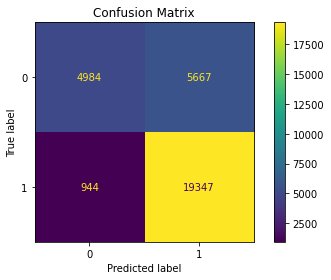

In [18]:
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

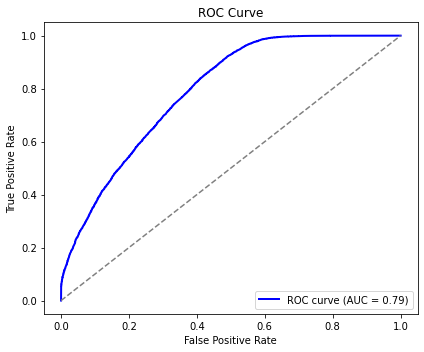

In [19]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_proba = model.predict_proba(X_test_final)[:, 1]

# Compute ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


Model 2

=== Ensemble Classification Report ===
              precision    recall  f1-score   support

           0       0.92      0.52      0.67     10651
           1       0.80      0.98      0.88     20291

    accuracy                           0.82     30942
   macro avg       0.86      0.75      0.77     30942
weighted avg       0.84      0.82      0.80     30942



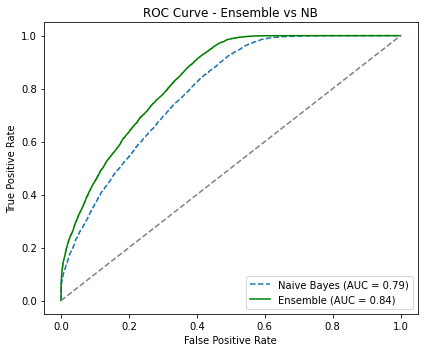

In [20]:
# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_final, y_train)

nb_probs = model.predict_proba(X_test_final)[:, 1]
lr_probs = lr_model.predict_proba(X_test_final)[:, 1]

ensemble_probs = (nb_probs + lr_probs) / 2
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# Evaluate Ensemble
print("=== Ensemble Classification Report ===")
print(classification_report(y_test, ensemble_preds))

# ROC Curve for Ensemble
fpr_ens, tpr_ens, _ = roc_curve(y_test, ensemble_probs)
roc_auc_ens = auc(fpr_ens, tpr_ens)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Naive Bayes (AUC = {roc_auc:.2f})', linestyle='--')
plt.plot(fpr_ens, tpr_ens, label=f'Ensemble (AUC = {roc_auc_ens:.2f})', color='green')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble vs NB')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


Model 3

=== Ensemble Routing Report ===
              precision    recall  f1-score   support

           0       0.89      0.54      0.67     10651
           1       0.80      0.96      0.87     20291

    accuracy                           0.82     30942
   macro avg       0.84      0.75      0.77     30942
weighted avg       0.83      0.82      0.81     30942



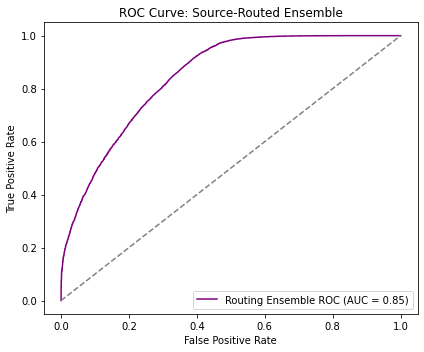

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc

# Load Data
fake_df = pd.read_csv("data/Fake.csv")
true_df = pd.read_csv("data/True.csv")
facts_df = pd.read_excel("data/filtered_fever_data.xlsx")

# Prep news data
fake_df['label'] = 0
true_df['label'] = 1
fake_df['content'] = fake_df['title'] + " " + fake_df['text']
true_df['content'] = true_df['title'] + " " + true_df['text']
news_df = pd.concat([fake_df[['content', 'label']], true_df[['content', 'label']]])

# Prep facts data
facts_df['label'] = facts_df['label'].map({'SUPPORTS': 1, 'REFUTES': 0})
facts_df.rename(columns={'claim': 'content'}, inplace=True)

# Merge all
merged_df = pd.concat([news_df, facts_df], ignore_index=True)
merged_df['source_type'] = merged_df['content'].apply(lambda x: 'claim' if len(x.split()) < 50 else 'article')

# Split
X_train, X_test, y_train, y_test, type_train, type_test = train_test_split(
    merged_df['content'], merged_df['label'], merged_df['source_type'], 
    test_size=0.2, stratify=merged_df['label'], random_state=42
)

# TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Split by source_type
X_train_claims = X_train_vec[np.array(type_train == 'claim')]
y_train_claims = y_train[type_train == 'claim']

X_train_articles = X_train_vec[np.array(type_train == 'article')]
y_train_articles = y_train[type_train == 'article']

X_test_claims = X_test_vec[np.array(type_test == 'claim')]
y_test_claims = y_test[type_test == 'claim']

X_test_articles = X_test_vec[np.array(type_test == 'article')]
y_test_articles = y_test[type_test == 'article']

# Train individual models
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_claims, y_train_claims)

nb_model = MultinomialNB()
nb_model.fit(X_train_articles, y_train_articles)

# Predict
claims_preds = lr_model.predict(X_test_claims)
claims_probs = lr_model.predict_proba(X_test_claims)[:, 1]

articles_preds = nb_model.predict(X_test_articles)
articles_probs = nb_model.predict_proba(X_test_articles)[:, 1]

# Combine
final_preds = np.zeros(X_test_vec.shape[0])
final_probs = np.zeros(X_test_vec.shape[0])

claim_indices = np.where(type_test == 'claim')[0]
article_indices = np.where(type_test == 'article')[0]

final_preds[claim_indices] = claims_preds
final_preds[article_indices] = articles_preds

final_probs[claim_indices] = claims_probs
final_probs[article_indices] = articles_probs

# Report
print("=== Ensemble Routing Report ===")
print(classification_report(y_test, final_preds))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, final_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Routing Ensemble ROC (AUC = {roc_auc:.2f})', color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Source-Routed Ensemble")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
